# Scaling Linear Algebra algorithms

Traditional "dense" linear algebra algorithms are $O(m^3)$ for $m \times m$ matrices, e.g. to solve a linear system or to compute eigenvalues.

What does this mean for the size of the systems that we can solve?

Let's try a couple of examples:

In [1]:
using LinearAlgebra, BenchmarkTools

Let's try a $1000 \times 1000$ matrix, which would have been unimaginably huge 100 years ago but is now a relatively "small" problem:

In [2]:
A = randn(1000,1000);

How long does it take to solve $Ax = b$?

In [3]:
b = randn(1000);

In [4]:
@btime x = $A \ $b; # solves Ax=b

  6.253 ms (9 allocations: 7.64 MiB)


Only about 6ms on my laptop!   Most of this time is spent on LU factorization (Gaussian elimination):

In [5]:
@btime lu($A);

  6.062 ms (6 allocations: 7.64 MiB)


So, you can solve a $1000 \times 1000$ system routinely, without breaking a sweat.

However, how long would it take for $10^6 \times 10^6$?

The cost of Gaussian elimination scales as $O(m^3)$, and $m = 10^6$ is 1000x bigger than $m=1000$, so the *cost* should be **1000³x** bigger (assuming that we can run such a problem on the same computer, with computations occurring at the same rate).  So time should be $\sim 1000^3$ times more, assuming everything else equal.

I won't attempt this computation on my laptop, but let's just multiply 6ms by $1000^3$ to estimate the runtime in seconds:

In [6]:
6e-3 * 1000^3

6.0e6

To make this time digestible to humans, let's convert seconds to **days**:

In [7]:
6e-3 * 1000^3 / 60 / 60 / 24

69.44444444444444

So, it would take **more than two months**.

However, we have a bigger problem: I'll run out of memory first!

A $10^6 \times 10^6$ matrix is $10^{12}$ numbers.  In double precision (`Float64`), there are 8 bytes per number.

This is **8 terabytes**, almost 1000x the amount of RAM on my laptop.

In practice, when working with large matrices, you typically run out of memory before running out of time!

Just use a parallel computer?   Suppose I give you 1000x more processors.   You can only solve 10x bigger problem in the same time (assuming $m^3$ scaling holds exactly).

This is for Gaussian elimination.  The cost of other operations is even worse.  For example, here is the cost for diagonalization (eigenvalues and eigenvectors) of our $1000 \times 1000$ matrix:

In [8]:
@btime eigen($A);

  359.610 ms (41 allocations: 31.59 MiB)


The time went from 6ms to 350ms, more than **50x** slower.  It's still $O(m^3)$, but the "constant factor" is a lot worse.

Computing just the eigenvalues is a bit faster, but still $O(m^3)$:

In [9]:
@btime eigvals($A);

  273.246 ms (30 allocations: 7.95 MiB)


## Structured Sparsity: a symmetric tridiagonal matrix

To do better, and to handle huge matrices $\gg 1000 \times 1000$, we need to exploit some kind of special structure of the matrix.

The most common structure to exploit is **sparsity: where the matrix entries are mostly zero**.

An extra special example of sparsity is a **symmetric tridiagonal matrix**.  This structure is so common that Julia actually has a special type to represent it.  Let's try a $5 \times 5$ example to make it easy to see:

In [10]:
N = 5
A = SymTridiagonal(fill(-2, N), fill(1, N-1))

5×5 SymTridiagonal{Int64, Vector{Int64}}:
 -2   1   ⋅   ⋅   ⋅
  1  -2   1   ⋅   ⋅
  ⋅   1  -2   1   ⋅
  ⋅   ⋅   1  -2   1
  ⋅   ⋅   ⋅   1  -2

The "dots" here represent zero entries that are not actually stored.  If we "dump" the data structure for `A` we'll see that internally it only stores two 1d arrays: $N$ diagonal entries and $N-1$ off-diagonal entries:

In [11]:
dump(A)

SymTridiagonal{Int64, Vector{Int64}}
  dv: Array{Int64}((5,)) [-2, -2, -2, -2, -2]
  ev: Array{Int64}((4,)) [1, 1, 1, 1]


If you *invert* a sparse matrix, in general you will get *all nonzero* entries (a "dense" matrix).   The usual advice to avoid computing explicit inverses is especially true for sparse matrices!

In [12]:
inv(A)

5×5 Matrix{Float64}:
 -0.833333  -0.666667  -0.5  -0.333333  -0.166667
 -0.666667  -1.33333   -1.0  -0.666667  -0.333333
 -0.5       -1.0       -1.5  -1.0       -0.5
 -0.333333  -0.666667  -1.0  -1.33333   -0.666667
 -0.166667  -0.333333  -0.5  -0.666667  -0.833333

This matrix is a "discretized Laplacian" and its inverse actually has a very special pattern that we can see if we plot the columns of the inverse.

Physically, each column corresponds to "pushing down on a stretched string" at one point.

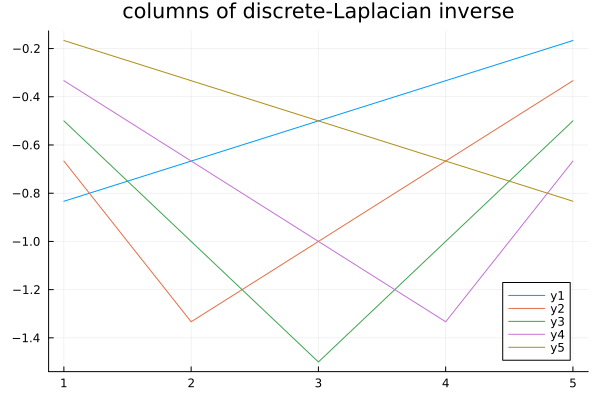

In [13]:
using Plots
plot(inv(A), title="columns of discrete-Laplacian inverse")

Now, let's try a much bigger symmetric tridiagonal matrix: $N = 10^7$.

Storing this matrix is no problem, since we only need to store about $2 \times 10^7$ numbers, or about 160MB.  (Well within the capability of my laptop in 2025.  40 years ago this would have been considered huge.)

In [14]:
N = 10^7
A = SymTridiagonal(fill(-2, N), fill(1, N-1))

10000000×10000000 SymTridiagonal{Int64, Vector{Int64}}:
 -2   1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  1  -2   1   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   1  -2   1   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   1  -2   1   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   1  -2   1   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   1  -2   1   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   1  -2   1   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   1  -2   1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   1  -2      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   1      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅  …   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅
  ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅   ⋅      ⋅  

Fortunately, Julia does not try to display the whole matrix on my screen!

Now, let's solve $A u = f$ for this system, for a random $f$:

In [15]:
f = randn(N);

In [16]:
@btime u = $A \ $f;

  109.720 ms (9 allocations: 228.88 MiB)


It took only ≈ 100ms on my laptop!

It turns out that one can solve $N \times N$ tridiagonal systems of equations in $O(N)$ time and $O(N)$ memory.

How can we generalize this to other sparsity patterns and other types of matrix structures?